In [ ]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
pip install pandas numpy matplotlib requests scikit-learn

Class distribution in 'signal' before adjustment:
 signal
0    3871
Name: count, dtype: int64
Only one class detected, adding simulated 'buy' signals for training.
Class distribution in 'signal' after adjustment:
 signal
0    3871
1       5
Name: count, dtype: int64

Training data preview:
    sentiment_score   price  volume        rsi
13              0.0  170.21   309.0  33.043478
14              0.0  170.21   202.0  33.043478
15              0.0  170.20   423.0  44.186047
16              0.0  170.15   305.0  35.365854
17              0.0  170.10  2698.0  34.939759 13    0
14    0
15    0
16    0
17    0
Name: signal, dtype: int64
Model Accuracy: 0.9987113402061856
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       0.00      0.00      0.00         1

    accuracy                           1.00       776
   macro avg       0.50      0.50      0.50       776
weighted avg       1.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


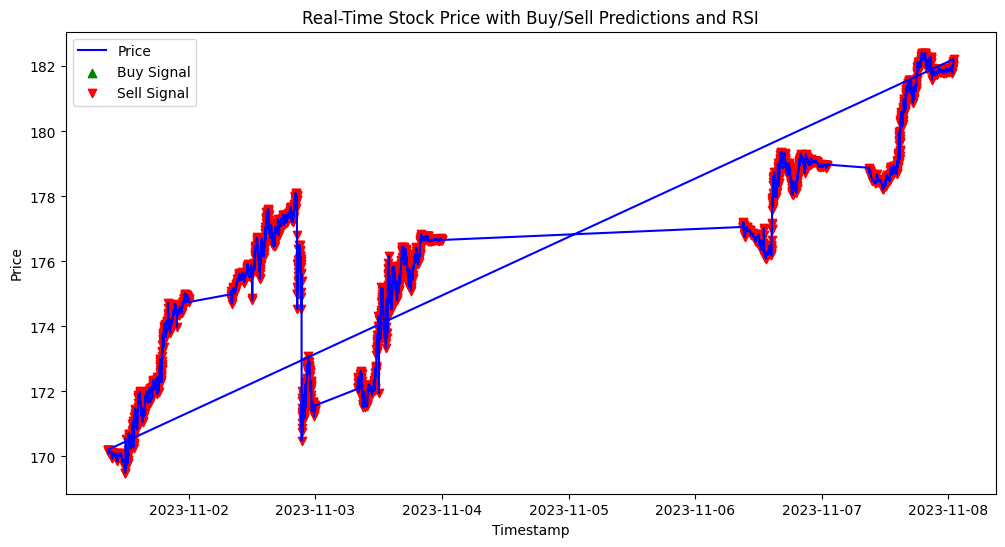

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

API_KEY = 'uc4qBrNqdgTrUYp1p75ze9HMu7_2802Z'

analyzer = SentimentIntensityAnalyzer()

def fetch_real_time_data(ticker="AAPL"):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/2023-11-01/2023-11-07?apiKey={API_KEY}"
    response = requests.get(url)
    data = response.json()
    return data.get('results', [])

# RSI
def calculate_rsi(df, period=14):
    delta = df['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    df['rsi'] = rsi
    return df

def process_data(data):
    if not data:
        raise ValueError("No data fetched from Polygon.io API.")

    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['t'], unit='ms')
    df['price'] = df['c']
    df['volume'] = df['v']

    df = calculate_rsi(df)
    df['sentiment_score'] = df['price'].pct_change().apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    df['signal'] = df['sentiment_score'].apply(lambda x: 1 if x > 0.05 else 0)

    df.dropna(inplace=True)

    print("Class distribution in 'signal' before adjustment:\n", df['signal'].value_counts())

    if len(df['signal'].value_counts()) < 2:
        print("Only one class detected, adding simulated 'buy' signals for training.")
        simulated_buy = df.iloc[:5].copy()
        simulated_buy['signal'] = 1
        df = pd.concat([df, simulated_buy])

    print("Class distribution in 'signal' after adjustment:\n", df['signal'].value_counts())

    return df

# ml model
def train_model(df):
    X = df[['sentiment_score', 'price', 'volume', 'rsi']]
    y = df['signal']

    if X.isnull().values.any() or not np.isfinite(X).all().all():
        print("Feature matrix X contains NaN or infinite values:")
        print(X)
        raise ValueError("Feature matrix X contains NaN or infinite values")
    if y.isnull().values.any():
        print("Target vector y contains NaN values:")
        print(y)
        raise ValueError("Target vector y contains NaN values")

    print("\nTraining data preview:")
    print(X.head(), y.head())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    return model

def predict_signal(model, df):
    predictions = model.predict(df[['sentiment_score', 'price', 'volume', 'rsi']])
    df['predicted_signal'] = predictions
    return df

data = fetch_real_time_data(ticker="AAPL")
processed_data = process_data(data)
model = train_model(processed_data)
predicted_data = predict_signal(model, processed_data)

plt.figure(figsize=(12, 6))
plt.plot(processed_data['timestamp'], processed_data['price'], label='Price', color='blue')
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 1]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 1]['price'],
            color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(predicted_data[predicted_data['predicted_signal'] == 0]['timestamp'],
            predicted_data[predicted_data['predicted_signal'] == 0]['price'],
            color='red', label='Sell Signal', marker='v', alpha=1)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Real-Time Stock Price with Buy/Sell Predictions and RSI')
plt.legend()
plt.show()


In [ ]:
# !pip install yfinance -q

In [ ]:
import yfinance as yf
import plotly.graph_objects as go

In [ ]:
aapl = yf.Ticker("AAPL")

In [ ]:
hist = aapl.history(period="max")

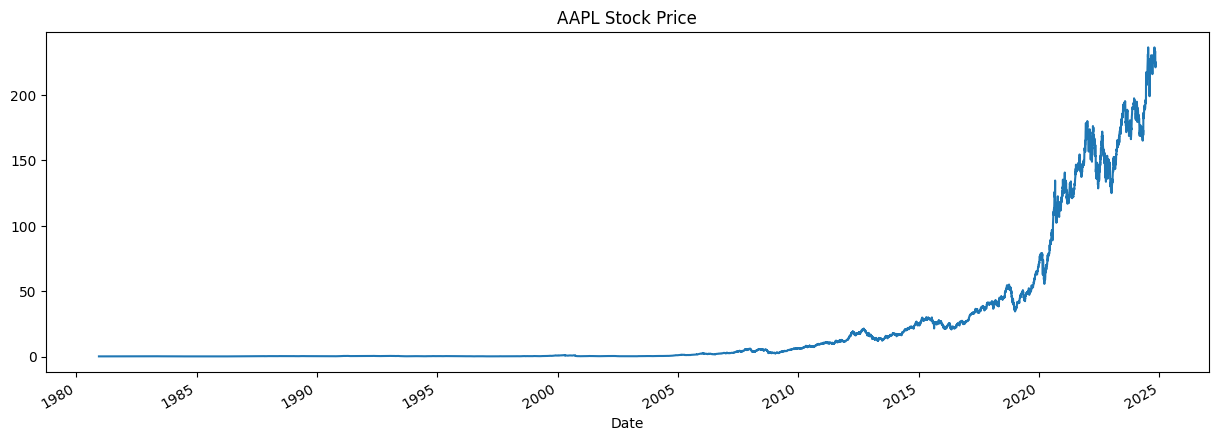

In [ ]:
hist["Open"].plot(figsize=(15, 5), title="AAPL Stock Price")
plt.show()

In [ ]:
stonks = ["AAPL"]

In [ ]:
hists = {}
for s in stonks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="1d")
    hists[s] = history

In [ ]:
for stock in stonks:
    temp_df = hists[stock].copy()

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=300,
        paper_bgcolor="LightSteelBlue",
        title=stock,
    )

    fig.show()

In [ ]:
import nltk
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import datetime

nltk.download('vader_lexicon')

finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL']

news_tables = {}

for ticker in tickers:
    try:
        url = finviz_url + ticker
        req = Request(url=url, headers={'user-agent': 'Mozilla/5.0'})
        response = urlopen(req)
        html = BeautifulSoup(response, 'html.parser')
        news_table = html.find(id='news-table')

        if news_table:
            news_tables[ticker] = news_table
        else:
            print(f"Warning: No news table found for {ticker}")

    except Exception as e:
        print(f"Error scraping {ticker}: {e}")

# Parsing
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        try:
            title = row.a.text if row.a else "No title available"
            date_data = row.td.text.split(' ')

            if len(date_data) == 1:
                time = date_data[0]
                date = datetime.datetime.today().strftime('%Y-%m-%d')
            else:
                date = date_data[0]
                time = date_data[1]

            parsed_data.append([ticker, date, time, title])

        except Exception as e:
            print(f"Error parsing row: {e}")

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

show_data = input("Do you want to display the scraped data before analyzing? (yes/no): ").strip().lower()
if show_data == 'yes':
    print("\nScraped Data:\n")
    print(df.head(20))

df['date'] = pd.to_datetime(df['date'], errors='coerce')

# VADER
vader = SentimentIntensityAnalyzer()

def analyze_sentiment(title):
    sentiment = vader.polarity_scores(title)
    return pd.Series({
        'compound': sentiment['compound'],
        'positive': sentiment['pos'],
        'neutral': sentiment['neu'],
        'negative': sentiment['neg']
    })

df[['compound', 'positive', 'neutral', 'negative']] = df['title'].apply(analyze_sentiment)

df.drop(columns=['time'], inplace=True)

numeric_columns = ['compound', 'positive', 'neutral', 'negative']
df_grouped = df.groupby(['date', 'ticker'])[numeric_columns].mean()

plt.figure(figsize=(12, 6))
for ticker in tickers:
    ticker_data = df_grouped.xs(ticker, level='ticker')
    plt.plot(ticker_data.index, ticker_data['compound'], marker='o', label=ticker)

plt.title('Average Sentiment Over Time by Ticker')
plt.ylabel('Compound Sentiment Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend(title='Ticker')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
mean_df = df.groupby(['ticker'])[numeric_columns].mean()
mean_df[['compound']].plot(kind='bar', color=['#1f77b4'])
plt.title('Average Sentiment by Ticker')
plt.ylabel('Average Compound Sentiment Score')
plt.xlabel('Ticker')
plt.tight_layout()
plt.show()

df.to_csv('scraped_news_sentiment.csv', index=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Do you want to display the scraped data before analyzing? (yes/no): yes

Scraped Data:

   ticker  date time                                              title
0    AAPL  \r\n       Match Group (MTCH) Q3 2024 Earnings Call Trans...
1    AAPL  \r\n       Nvidia surpasses $3.6 trillion market value af...
2    AAPL  \r\n       ANZ Profit Drops as Competition Bites in Home-...
3    AAPL  \r\n       Qualcomm Stock Loses Ground After Solid Earnin...
4    AAPL  \r\n       Jim Cramer Admits Apple (AAPL) is a Changing S...
5    AAPL  \r\n       Big Tech CEOs rush to congratulate Trump on el...
6    AAPL  \r\n       Apple 16-inch MacBook Pro (M4 Pro) review: A p...
7    AAPL  \r\n       Should You Forget Apple? Why You Might Want to...
8    AAPL  \r\n       Apple Inc. (AAPL) to Launch iOS 18.2 with Chat...
9    AAPL  \r\n       Prediction: This Relentless Vanguard ETF Will ...
10   AAPL  \r\n       Is Apple Inc. (AAPL) a Good Stock to Buy Now A...
11   AAPL  \r\n       Warren Buffett Owns 4 Stoc

KeyError: 'AAPL'

<Figure size 1200x600 with 0 Axes>